# XXZ Spin-chain dynamics 

Here we simulate an spin-chain with a Hamiltonian with periodic boundary conditions for a long time and we are interested in the time-dependent behaviour of a local observable. Here we choose to look at the local magnetization $\vec{s}_l(t) = \left\langle \vec{\sigma}_l(t)\right\rangle$. The Hamiltonian is 

$$ H = \sum \limits_{i}{\sigma^x_i \sigma^x_{i+1} + \sigma^y_i \sigma^y_{i+1} + \Delta \sigma^z_i \sigma^z_{i+1}}$$


In [2]:
import numpy as np
import dit
import time
import numpy.linalg as LA
import scipy.linalg as sLA
import matplotlib.pyplot as plt

Parameters of the simulation 

In [3]:
#size of chain
L = 8

#size of timestep
dt = 0.05

#Interaction strength
DEL = 0.2

Pauli matrices plus 2-by-2 identity matrix definition

In [4]:
sx = np.array([[0,1],[1,0]])
sy = np.array([[0, -1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
one = np.array([[1,0],[0,1]])

Check that the operator kron does what it is supposed to 

In [5]:
np.kron(one,sx)

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

Define the operators that represents the local spin in matrix form. Use the Kronecker product.

In [6]:
SX = []
for i in range(L):
    left = np.identity(2**(i))
    right = np.identity(2**(L-i-1))
    tens1 = np.kron(left, sx)
    tens2 = np.kron(tens1,right)
    SX.append(tens2)

SY = []
for i in range(L):
    left = np.identity(2**(i))
    right = np.identity(2**(L-i-1))
    tens1 = np.kron(left, sy)
    tens2 = np.kron(tens1,right)
    SY.append(tens2)

SZ = []
for i in range(L):
    left = np.identity(2**(i))
    right = np.identity(2**(L-i-1))
    tens1 = np.kron(left, sz)
    tens2 = np.kron(tens1,right)
    SZ.append(tens2)

Initialize the Hamiltonian to a all-zero matrix and then define the actual model

In [7]:
H = np.zeros([2**L,2**L])

In [8]:
for i in range(L-1):
    H = H + np.matmul(SX[i],SX[i+1])+ np.matmul(SY[i],SY[i+1]) + DEL*np.matmul(SZ[i],SZ[i+1])

H = H + np.matmul(SX[L-1],SX[0])+ np.matmul(SY[L-1],SY[0]) + DEL*np.matmul(SZ[L-1],SZ[0])

Compute eigenvalues and eigenvectors

In [9]:
e_val, e_vec = LA.eigh(H)

#Sort them according to energy
idx = e_val.argsort()[::-1]   
e_val = e_val[idx]
e_vec = e_vec[:,idx]
#This needs to happen so that the eigenvectors are column-vectors and not row-vectors
e_vec=e_vec.transpose()

In [10]:
e_vec[0].shape

(256,)

In [11]:
#use it if you are not sure about the shape of the vectors coming out
for k in range(0,3):
    vet = np.dot(H,e_vec[k])-e_val[k]*(e_vec[k])
    print(np.sqrt(np.vdot(vet,vet)))

(1.04644853542e-14+0j)
(8.8174291327e-15+0j)
(7.33349868834e-15+0j)


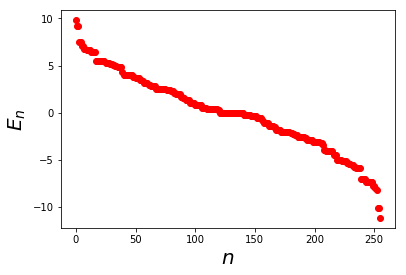

In [12]:
plt.plot(np.linspace(0,2**L-1,2**L),e_val.real,'ro')
plt.xlabel('$n$',fontsize=20)
plt.ylabel('$E_n$',fontsize=20)
plt.show()

Define the unitary propagator

In [13]:
unit = sLA.expm(-1j*H*dt)

Choose the initial state $\left\vert \psi_0 \right\rangle$

In [14]:
s = str('')
if np.mod(L, 2) == 0:
    for i in range(int(L/2)):
        s += '01'  
else:
    for i in range(int(L/2)):
        s += '01'
    s += '0'        

In [15]:
#Use the code before to select the Antiferromagnetic order or simply input a sequence of 0 and 1
#num = int(s, 2)
num = int(s, 2)

In [16]:
init = np.zeros(2**L)

In [17]:
init[num] = 1
init.shape

(256,)

In [18]:
#Check here that the magnetication profile is the correct one
for k in range(0,L):
    print(np.matmul(init.conj().T,np.matmul(SZ[k],init)))

1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0


Find here some useful parameters of the model and initial state.

Average Energy =  -1.6
Energy Standard Deviation =  5.65685424949


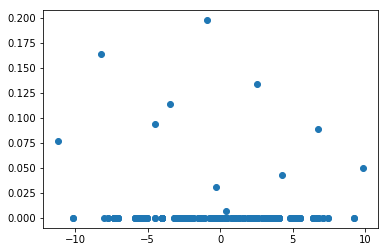

In [19]:
Energy_Ave = np.dot(init.conj().T,np.dot(H,init))
Energy_Std = (np.matmul(init.conj().T,np.matmul(H,np.matmul(H,init))) - Energy_Ave**2)**0.5
print('Average Energy = ',Energy_Ave.real)
print('Energy Standard Deviation = ',Energy_Std.real)
PE = np.zeros(2**L)
for k in range(0,2**L):
    PE[k]=abs(np.vdot(e_vec[k],init))**2
plt.plot(e_val,PE,'o')
plt.show()

In [20]:
delt=1/Energy_Std.real
print(delt/0.01)

17.6776695297


Now perform the discrete-time-evolution and record the value of the local magnetization vector, at every time-step. This creates the time-series we are interested in.

In [21]:
start_time = time.time()
timesteps = 1000000
mag_z = np.zeros((timesteps,L))
mag_x = np.zeros((timesteps,L))
mag_y = np.zeros((timesteps,L))
psi_t = init
for t in range(timesteps):

    if np.mod(t,20000) == 0:
        Time = time.time() - start_time 
        print('Iteration',t,'took a time t=',time.time() - start_time)
    psi_t = np.matmul(unit, psi_t)
    for i in range(L):
        mag_z[t][i] = float(np.real(np.matmul(psi_t.reshape((1,2**L)).conj(),np.matmul(SZ[i],psi_t))))
        mag_x[t][i] = float(np.real(np.matmul(psi_t.reshape((1,2**L)).conj(),np.matmul(SX[i],psi_t))))
        mag_y[t][i] = float(np.real(np.matmul(psi_t.reshape((1,2**L)).conj(),np.matmul(SY[i],psi_t))))

Iteration 0 took a time t= 0.0009539127349853516
Iteration 20000 took a time t= 67.41519689559937
Iteration 40000 took a time t= 138.5853180885315


KeyboardInterrupt: 

Once the simulation is done, we can plot a few things to check that everything is in order.

In [21]:
mag_z1 = [mag_z[t][0] for t in range(250)]
mag_x1 = [mag_x[t][0] for t in range(250)]
mag_y1 = [mag_y[t][0] for t in range(250)]

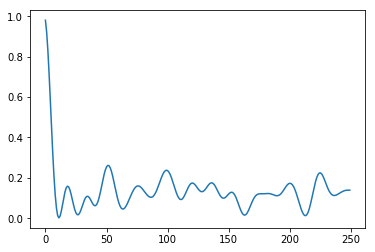

In [22]:
plt.plot(mag_z1)
plt.show()

In [23]:
np.save('./Data/LocalDyn_XXZ_DEL=0.2_dt=0.01_Nt=10**6_L='+str(L)+'_MagX.npy',mag_x)
np.save('./Data/LocalDyn_XXZ_DEL=0.2_dt=0.01_Nt=10**6_L='+str(L)+'_MagY.npy',mag_y)
np.save('./Data/LocalDyn_XXZ_DEL=0.2_dt=0.01_Nt=10**6_L='+str(L)+'_MagZ.npy',mag_z)